In [4]:
import pandas as pd
from time import time
import numpy as np
from tqdm import tqdm
import os
import netCDF4 as nc
from progressbar import progressbar
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import datetime
from matplotlib import pyplot as plt, rcParams
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib
from scipy.ndimage import gaussian_filter
import xarray as xr
import random
from scipy.interpolate import LinearNDInterpolator
from itertools import product
from scipy.signal import savgol_filter
tqdm.pandas()

from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
from matplotlib.patches import Rectangle
from random import random

%matplotlib inline

In [4]:
def get_smap(path: str):
    ds = nc.Dataset(path)
    sm = ds['Soil_Moisture_Retrieval_Data_AM']
    latitudes = []
    longitudes = []
    moistures = []
    times = []
    qfs = []

    for lat in range(len(sm['latitude'])):
        for long in range(len(sm['longitude'][lat])):
            latitudes.append(sm['latitude'][lat][long])
            longitudes.append(sm['longitude'][lat][long])
            moistures.append(sm['soil_moisture'][lat][long])
            times.append(sm['tb_time_utc'][lat][long])
            qfs.append(sm['retrieval_qual_flag'][lat][long])
            
    df = pd.DataFrame.from_dict({'lat': latitudes, 'long': longitudes, 'time': times, 'smap_sm': moistures, 'retrieval_qfs': qfs})

    # Filter out missing values
    smap_df = df[df['smap_sm'] != -9999.0]

    return smap_df


def get_smap_main(root_path: str) -> pd.DataFrame:
    first = True
    subdirs = []
    filenames = []

    for dir_name, subdir_list, file_list in os.walk(root_path):
        if first:
            subdirs = subdir_list
            first = False
        else:
            filenames.append(file_list[0])
    
    smap_df = pd.DataFrame()
    
    for i in progressbar(range(len(subdirs))):
        current_day = int(filenames[i].split('_')[4][6:8])
        current_month = int(filenames[i].split('_')[4][4:6])
        current_year = int(filenames[i].split('_')[4][:4])
        
        current_path = root_path + '/' + subdirs[i] + '/' + filenames[i]
        current_df = get_smap(current_path)
        smap_df = smap_df.append(current_df)

    smap_df = convert_time(smap_df)
    
    return smap_df


def convert_time(df: pd.DataFrame, reference_time=None) -> pd.DataFrame:
    if reference_time is None:
        ref_date = pd.Timestamp('2019-01-01T00:00:00.000Z')
    else:
        ref_date = pd.Timestamp(reference_time)

    df['time'] = df['time'].apply(lambda t: conv(t))
    df['time'] = df['time'].apply(lambda t: (t - ref_date).days * 24 + (t - ref_date).seconds / 3600)
    return df


def conv(t):
    try:
        return pd.Timestamp(t)
    except:
        return pd.Timestamp(t.split('.')[0] + '.000Z')

In [1]:
def universal_plot(df, target_value='swvl1', title=None, bar_title=None, vmin=None, vmax=None, save=None, dot_size=0.5, std=False, fig_size=None, regions=None, region_colors=None, region_names=None):
    
    if fig_size is not None:
        plt.rcParams["figure.figsize"] = fig_size
    else:
        plt.rcParams["figure.figsize"] = (8,8)
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    lat_list, long_list = get_plot_ticks(df['lat'], df['long'])
    ax.set_xticks(long_list, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_list, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    if std:
        cmap = 'Greys'
    else:
        cmap = 'Spectral'
        
    if vmin is not None:
        plt.scatter(df['long'], df['lat'], c=list(df[target_value]), s=dot_size, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        plt.scatter(df['long'], df['lat'], c=list(df[target_value]), s=dot_size, cmap=cmap)
    
    bar = plt.colorbar(shrink=0.7)
    bar.ax.tick_params(labelsize=15)
    if bar_title is not None:
        bar.ax.set_title(bar_title, fontsize=18)
    
    if title is not None:
        plt.title(title, fontsize=20, fontweight='book')
    
    if regions is not None:
        legend_elements = []
        
        for i in range(len(regions)):
            ax.add_patch(regions[i])
            legend_elements.append(Line2D([0], [0], color=region_colors[i], lw=3, label=region_names[i]))

        ax.legend(handles=legend_elements, loc='upper right', fontsize=16)
        
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude', fontsize=18)
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight')

    plt.show()
    
    
def get_plot_ticks(lat_values, long_values):
    min_lat = min(lat_values)
    max_lat = max(lat_values)
    min_long = min(long_values)
    max_long = max(long_values)
    
    lat_step_size = (max_lat - min_lat) / 3
    long_step_size = (max_long - min_long) / 3
    
    long_list = [min_long, min_long + long_step_size, min_long + 2 * long_step_size, max_long]
    lat_list = [min_lat, min_lat + lat_step_size, min_lat + 2 * lat_step_size, max_lat]
    
    # Rounding to two decimals
    long_list = [round(num, 2) for num in long_list]
    lat_list = [round(num, 2) for num in lat_list]
    
    return lat_list, long_list


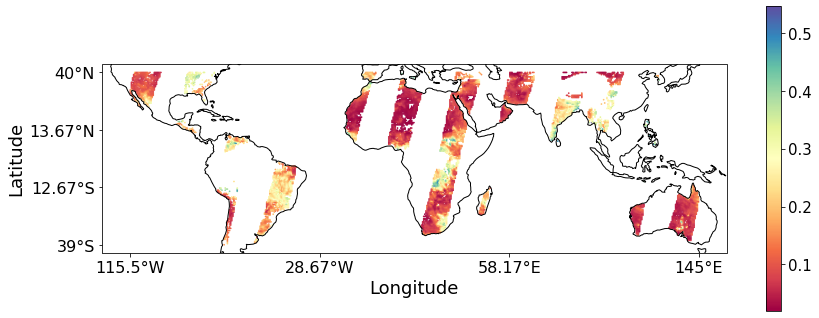

   Unnamed: 0   lat   long   smap_sm
0           0  30.5 -115.5  0.096900
1           1  31.0 -115.5  0.111975
2           2  31.5 -115.5  0.110818
3           3  32.0 -115.5  0.129354
4           4  29.5 -115.0  0.112069
0.5456759
0.020000529
0.13564305259381537
8538



1440

In [16]:
path = '/Users/vegardhaneberg/Desktop/test_smap.csv'


df = pd.read_csv(path)

universal_plot(df, 'smap_sm', fig_size=(14,8))

print(df.head())

print(df['smap_sm'].max())
print(df['smap_sm'].min())
print(df['smap_sm'].mean())
print(len(df))
